# NeuroDetect - A Brain Tumor Detection System
***
##### Author: Mayur Bhai
##### Contact: mayurbhai2324@gmail.com
##### Date: Sunday, December 8th, 2024

## Table of Contents
***

1. [Introduction](#Introduction)
2. [Dataset](#Dataset)
    - [Data Preparation](#Data-Preparation-and-Preprocessing)
    - [Data Preprocessing](#Data-Preprocessing)
3. [Modeling](#Modeling)
    - [Advance Convolutional Neural Network](#Advance-Convolutional-Neural-Network)
    - [Transfer Learning](#Transfer-Learning)
    - [Grad-Cam Visualization](#Grad-Cam-Visualization)
4. [Conclusion](#Conclusion)

## Introduction
***
We will continue from our previous notebook, but this time we will focus more on creating advance models that can accurately detect brain tumours and classify different types of tumours. The advance machine learning models that will be compared are an advance Convolutional Neural Network (built from the previous one) and a Transfer Learning method.

To quickly refresh, the primary goal of this project is to build a machine learning model that can **accurately detect the presence of a tumour in an MRI image and identify the tumour type.** This model aims to enhance the efficiency and precision of brain tumour diagnosis, supporting radiologists, surgeons, and researchers by:
- Reduce diagnostic times
- Reduce time for treatment planning
- Increasing patient turnaround
- Minimizing costs linked to misdiagnoses and incorrect treatments

**Using machine learning, how can we identify tumours in MRI scans to improve early detection, prevent further complications, and accelerate treatment planning?**


## Dataset
***

As a reminder, we will be using a mix of image data from various data sources all bundled into one folder. The dataset is a combination of the three datasets: figshare, SARTAJ dataset and the Br35H dataset. The dataset was combined collected from __[Kaggle.](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)__ The dataset contains 7023 MRI images of brain tumours classified into glioma, meningioma, pituitary and non-tumor. Images are already sorted and arranged to train and test folders within the **Data** directory.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import glob
import cv2
import random
#---------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
#---------------------------------------
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, Input, Lambda
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

#### Change Directory

First thing we'll do is to figure out where our current folder is located and change the directory so that it points to the folder with the image data. The os (Operating System) library will be used to determine that. We will set our base directory as the directory with the image data located.

**Google Colab was used for this notebook. You will need to mount Google Drive, ensuring the data file is inside a folder on your local Google Drive. To speed up image import times, the data file will be unzipped into Google Colab's local directory**

In [ ]:
# Check the current system directory
os.getcwd()

'/content'

In [ ]:
# Change directory so that it points to the folder with the data
os.chdir("/content/drive/MyDrive/neurodetect_capstone/data")
os.getcwd()

'/content/drive/MyDrive/neurodetect_capstone/data'

In [ ]:
# Unzip data file into folder on google colab
!unzip "/content/drive/My Drive/neurodetect_capstone/data/data.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0726.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0727.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0728.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0729.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0730.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0731.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0732.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0733.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0734.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0735.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0736.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0737.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0738.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_0739.jpg  
  inflating: /content/data/Training/glioma/Tr-gl_

In [ ]:
# Set base directory to the data folder
#base_dir = os.getcwd()
base_dir = "/content/data"


Define a function to prepare the dataset by taking a directory as input. This function will serve as the main tool to import image paths and labels from subfolders (without loading the actual images). By importing only paths and labels, we can efficiently examine and process the data without the overhead of loading all images. The image paths can later be used to load images as needed. The function returns lists of data paths and corresponding labels.

In [ ]:
def prepare_dataset(directory):
    '''
    This function takes in the path of the data directory, go through all image path, subfolders and combine it into
    2 arrays. Each element in array is the path to the image and the image label.

    Args:
        directory (str): Directory path for the data directory

    Returns:
        data_path (array): Return array of each image data path
        data_labels (array): Return array of each image labels

    Examples:
        >>> path, label = prepare_dataset(directory)
        >>> path
        [data/train/dog_image_1.jpg, data/train/cat_image_1.jpg]
        >>> label
        [dog, cat]
    '''

    # Lists to store data path and labels
    data_path = []
    data_labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)

    return data_path, data_labels

#### Data Preparation
Next, we'll begin loading and examining our data. First, we’ll set up the directory paths for both the training and test images. The dataset is structured so that images are already separated into their respective folders by class. We’ll load each image path and its label into a data frame and import all the images based on the image path.

In [ ]:
# Train and test directories
train_dir = base_dir + r'/Training/'
test_dir = base_dir + r'/Testing/'

# Getting data using above function
train_paths, train_labels = prepare_dataset(train_dir)
test_paths, test_labels = prepare_dataset(test_dir)

# Turn them into pandas DF
train_df = pd.DataFrame({'Class Path':train_paths, 'Class':train_labels})
test_df = pd.DataFrame({'Class Path':test_paths, 'Class':test_labels})

In [ ]:
# Shape of data frame and sanity check
print(train_df.shape)
print(test_df.shape)

(5712, 2)
(1311, 2)


In [ ]:
# Print train head
train_df.head()

,Class Path,Class
0,/content/data/Training/meningioma/Tr-me_0038.jpg,meningioma
1,/content/data/Training/meningioma/Tr-me_0832.jpg,meningioma
2,/content/data/Training/meningioma/Tr-me_0794.jpg,meningioma
3,/content/data/Training/meningioma/Tr-me_1167.jpg,meningioma
4,/content/data/Training/meningioma/Tr-me_1251.jpg,meningioma


In [ ]:
# Print test head
test_df.head()

,Class Path,Class
0,/content/data/Testing/meningioma/Te-me_0275.jpg,meningioma
1,/content/data/Testing/meningioma/Te-me_0162.jpg,meningioma
2,/content/data/Testing/meningioma/Te-me_0105.jpg,meningioma
3,/content/data/Testing/meningioma/Te-me_0152.jpg,meningioma
4,/content/data/Testing/meningioma/Te-me_0069.jpg,meningioma


#### Data Preprocessing
Next, we'll begin loading our images and labels based on the image paths in the dataframe. While loading, we will convert the images to grayscale and resize them to (128, 128) to ensure all image sizes are consistent. Once the images are loaded and split into training and testing sets, we will begin preprocessing them. The training and testing images (X_train and X_test) will be flattened for our non-deep learning models, and the training and testing labels (Y_train and Y_test) will be encoded to convert them from categorical string values to numerical values so that our model can understand them.

The function below takes in the dataframe containing the image paths and the desired image size for resizing. It resizes the images, converts them to grayscale, and outputs an array of images and labels.

In [ ]:
def load_images_and_labels(df, img_size=(64, 64)):
    """
    Load images and their corresponding labels from the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and class labels.
        img_size (tuple): Target size for resizing images (height, width).

    Returns:
        X (numpy.ndarray): Array of image data.
        y (numpy.ndarray): Array of labels encoded as integers.
    """
    images = []
    labels = []

    for _, row in df.iterrows():
        img_path = row['Class Path']
        label = row['Class']

        # Load the image from image path
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Image not found at {img_path}. Skipping.")
            continue

        # Resize the image
        img = cv2.resize(img, img_size)

        # Append to lists
        images.append(img)
        labels.append(label)

    # Convert lists to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    return X, y

In [ ]:
# Load training data
img_size = (128, 128)  # Set target image size
X_train, y_train = load_images_and_labels(train_df, img_size)
X_test, y_test = load_images_and_labels(test_df, img_size)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Sanity check
print("Shape of X_train:", X_train.shape)
print("Shape of Encoded y_train:", y_train_encoded.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Encoded y_test:", y_test_encoded.shape)

Shape of X_train: (5712, 128, 128)
Shape of Encoded y_train: (5712,)
Shape of X_test: (1311, 128, 128)
Shape of Encoded y_test: (1311,)


## Modeling
***

Now that our data has been imported and preprocessed, we can begin modeling Previous baseline models indicated that a Convolutional Neural Network (CNN) is the most effective approach. Before proceeding, let's review the baseline results as a refresher.

<br>

**Baseline Models Accuracy Results**

| Model             | Train Accuracy | Test Accuracy |
|:-------------------:|:----------------:|:---------------:|
| Logistic Regression | 89.74%         | 81.46%        |
| Support Vector Machine (SVM) | 92.49%         | 88.33%        |
| Random Forest      | 83.96%         | 75.97%        |
| Convolutional Neural Network (CNN) | 95.95% | 90.69% |


**Baseline Models Recall Results**

| Model                         | No Tumor Recall | Pituitary Recall | Glioma Recall | Meningioma Recall |
|:-------------------------------:|:-----------------:|:------------------:|:---------------:|:-------------------:|
| Logistic Regression            | 95%             | 95%              | 71%           | 61%               |
| Support Vector Machine (SVM)   | 97%             | 97%              | 82%           | 75%               |
| Random Forest                  | 93%             | 92%              | 63%           | 51%               |
| Convolutional Neural Network (CNN) | 99% | 95% | 93% | 68% |

<br>

As observed previously, our baseline CNN model delivered the best performance. Building on this foundation, we will develop a more advanced CNN model and fine-tune its layers and parameters to achieve the highest possible accuracy. Additionally, we will perform transfer learning using the ResNet50 model to compare the effectiveness of a pre-trained model against our custom-built model.

#### Advance Convolutional Neural Network

We will build on top of our baseline model and create a more advanced Convolutional Neural Network (CNN) model. CNNs are deep learning models that are widely regarded as the go-to solution for computer vision problems. To create a robust model capable of accurately detecting brain tumors, we will introduce a more complex architecture with multiple layers, increased epochs, early stopping, and dropout nodes to prevent overfitting.

We will begin by setting a random seed to ensure reproducibility.

In [ ]:
def set_random_seed(seed):

    '''Random seeds for reproducability'''

    random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
set_random_seed(42)

Neural Network models require separate validation, training, and test sets. While we could split our training set 80/20 to create a validation set, this would reduce the size of our training data and could lead to the model performing better than expected due to an insufficiently representative validation set. To address this, we will split our test set in half and use one portion as the validation set.

In [ ]:
# Split the test data into validation and test sets
X_val, X_test, y_val_encoded, y_test_encoded = train_test_split(X_test, y_test_encoded, test_size=0.5, random_state=42)

In [ ]:
# Sanity Check
print("Shape of X_train:", X_train.shape)
print("Shape of Encoded y_train:", y_train_encoded.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Encoded y_test:", y_test_encoded.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Encoded y_val:", y_val_encoded.shape)

Shape of X_train: (5712, 128, 128)
Shape of Encoded y_train: (5712,)
Shape of X_test: (656, 128, 128)
Shape of Encoded y_test: (656,)
Shape of X_val: (655, 128, 128)
Shape of Encoded y_val: (655,)


Since our images are divided into multiple classes, we will one-hot encode the labels into binary values and use them in our model. For the loss function, we will use categorical_crossentropy.

In [ ]:
# Convert labels to one-hot encoding for multi-class classification
num_classes = len(label_encoder.classes_)

y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes=num_classes)

We must normalize and preprocess our images further before using them in our model. All our X variables will be normalized so that their values fall between 0 and 1.

In [ ]:
# Normalize the image data
if X_train.max() > 1.0:
  X_train = X_train.astype('float32') / 255.0
  X_test = X_test.astype('float32') / 255.0
  X_val = X_val.astype('float32') / 255.0
  print(f"Normalized X_train range: {X_train.min()}-{X_train.max()}")
else:
  print("No further normalization needed.")

Normalized X_train range: 0.0-1.0


Build a advance CNN model.

In [ ]:
#Define the CNN model
CNN_model_2 = Sequential()

CNN_model_2.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (128, 128, 1)))
CNN_model_2.add(BatchNormalization())
CNN_model_2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_2.add(Dropout(0.25))

CNN_model_2.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model_2.add(BatchNormalization())
CNN_model_2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_2.add(Dropout(0.25))

CNN_model_2.add(Conv2D(128, (3, 3), activation='relu'))
CNN_model_2.add(BatchNormalization())
CNN_model_2.add(MaxPooling2D(pool_size=(2, 2)))


# Flatten the output of our convolutional layers
CNN_model_2.add(Flatten())

# Fully connected (Dense) Layer
CNN_model_2.add(Dense(128, activation='relu'))
CNN_model_2.add(Dense(num_classes, activation='softmax'))

# Print out a summary of the network
CNN_model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,476 (12.61 MB)

 Trainable params: 3,305,028 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Compile model
CNN_model_2.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
# Set up early stop of patience of 3 and monitor the validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           mode='min',
                           restore_best_weights=True,
                           verbose=1)

In [ ]:
# Fit CNN model
history = CNN_model_2.fit(X_train, y_train_onehot,
                          epochs=50,
                          batch_size=32,
                          validation_data=(X_val, y_val_onehot),
                          callbacks=[early_stop])

In [ ]:
# Evaluate the model's performance on the test data
score = CNN_model_2.evaluate(X_test, y_test_onehot, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9684 - loss: 0.1024
Test loss: 0.12015504390001297
Test accuracy: 0.9649389982223511


In [ ]:
# Predict labels
y_pred_cnn = CNN_model_2.predict(X_test).argmax(axis=1)

# Classification Report
print("CNN Classification Report:")
print(classification_report(y_test_encoded, y_pred_cnn, target_names=label_encoder.classes_))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
CNN Classification Report:
              precision    recall  f1-score   support

      glioma       0.90      0.98      0.94       144
  meningioma       0.98      0.87      0.92       154
     notumor       0.99      1.00      0.99       209
   pituitary       0.99      1.00      1.00       149

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.97      0.96      0.96       656



The advanced CNN model achieved a test accuracy of 96.49% and a test loss of 0.10, demonstrating strong overall performance. The model excelled in predicting the 'pituitary' and 'no tumor' classes, achieving precision and recall scores of 1.00 each. Notably, the model showed significant improvement in detecting 'meningioma,' with its recall score increasing to 0.87 compared to 0.68 in the baseline model. The 'glioma' class also displayed balanced performance with an F1-score of 0.94.

Overall, the advanced model outperformed the baseline CNN, which had an accuracy of 90.69%. However, there may be slight overfitting for the 'pituitary' and 'no tumor' classes, despite the use of multiple dropout layers and early stopping.

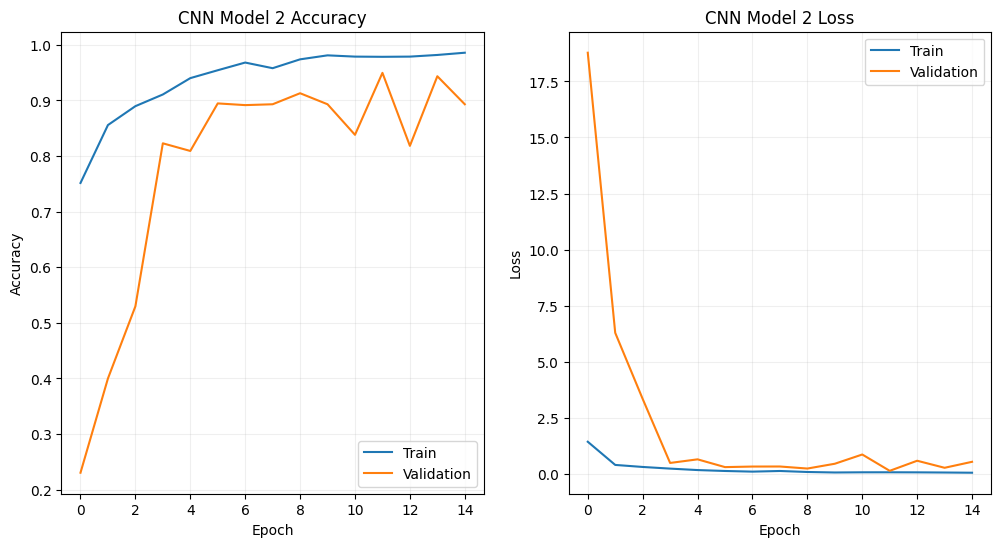

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], )
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('CNN Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('CNN Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

Analyzing the accuracy and loss graphs, we observe an interesting trend. There are two significant dips in accuracy, one at epoch 10 and another at epoch 12. However, the model was able to recover in the subsequent epochs. A similar pattern is seen in the loss curve, where the loss steadily decreases, indicating continuous model improvement before training stops at epoch 14.

Overall, both the training and validation accuracy show a consistent upward trend, suggesting that the model is learning effectively. The steady decline in loss further supports this observation.

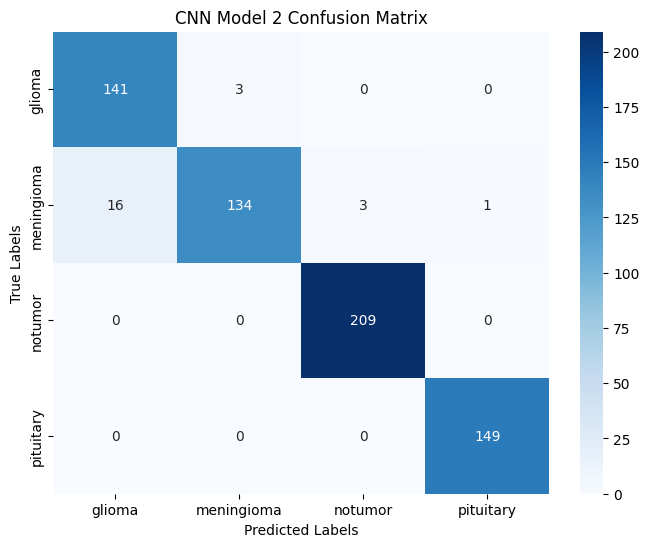

In [ ]:
# Print confusion matrix
con_matrix_cnn_2 = confusion_matrix(y_test_encoded, y_pred_cnn)
class_names = label_encoder.classes_

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(con_matrix_cnn_2, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("CNN Model 2 Confusion Matrix")
plt.show()

Analyzing the confusion matrix, we observe that our advanced CNN model performs significantly better than the baseline model. While the model still faces slight difficulty in classifying images from the 'meningioma' class, there is notable improvement. It misclassified 16 'meningioma' images as 'glioma,' down from 27 in the baseline model, and only 3 as 'no tumor,' compared to 19 previously.

Notably, the 'no tumor' and 'pituitary' classes had zero misclassifications. Overall, the model shows significant improvement, with a substantial reduction in misclassifications across classes.

Next, we will review some examples of the misclassified images by displaying all the incorrect predictions alongside their correct labels.

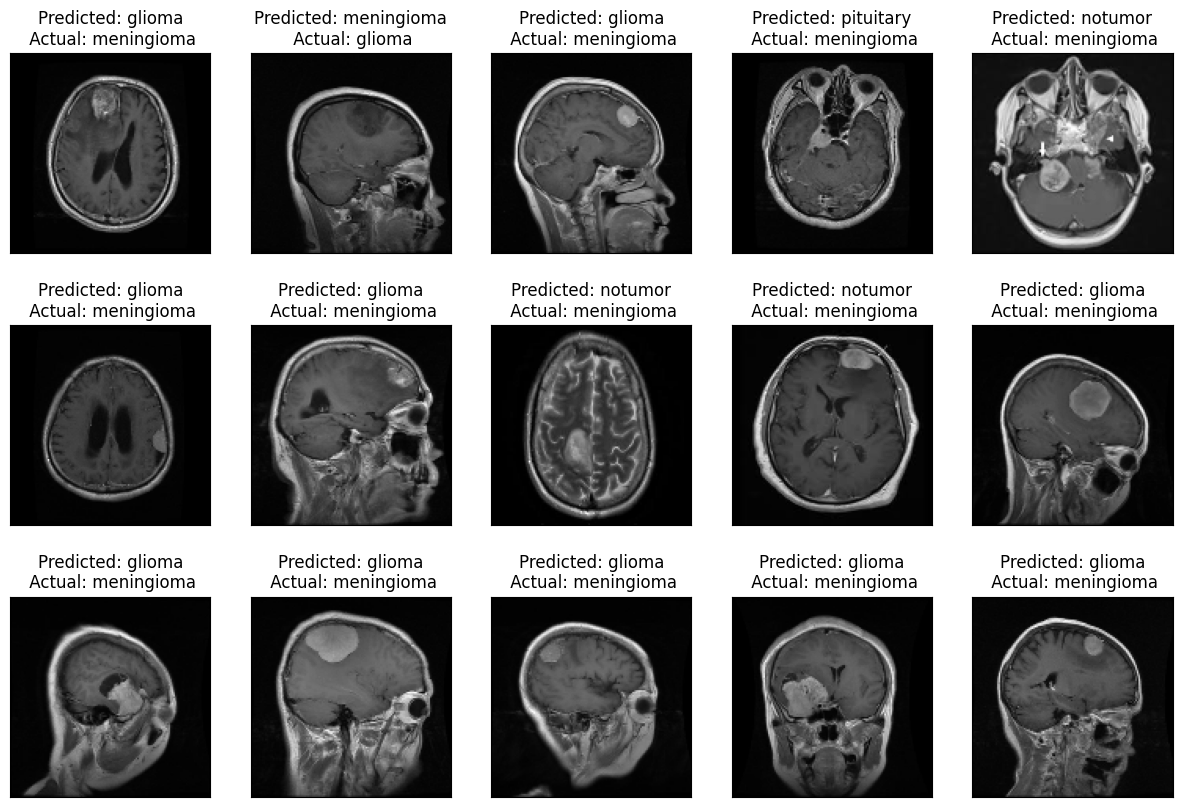

In [ ]:
# Grab the incorrect images
incorrect_photos = y_test_encoded != y_pred_cnn

# Set up number of images and the configuration (row x col)
num_images = 15
columns = 5
rows = 3

# Set up subplot
fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 10))

# Flatten axes
ax = ax.flatten()

# Display incorrect images
for i, image in enumerate(X_test[incorrect_photos][:num_images]):
    ax[i].imshow(image, cmap='gray')

    # Get predicted label
    prediction = label_encoder.inverse_transform(y_pred_cnn[incorrect_photos])[i]

    # Get actual label
    actual = label_encoder.inverse_transform(y_test_encoded[incorrect_photos])[i]

    # Set the title of the subplot
    ax[i].set_title(f"Predicted: {prediction}\n Actual: {actual}")

    # Hide the x and y ticks to make
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()
fig.tight_layout()

Once again, we observe that many 'meningioma' images are being misclassified. A common pattern among these misclassified images is the presence of a large, visually noticeable tumor, which the model struggles to classify correctly. In most cases, these images are misclassified as 'glioma.'

This challenge reflects a real-world issue, as 'glioma' and 'meningioma' tumors often have similar shapes and sizes, making them difficult to distinguish — even for medical professionals.

In [ ]:
# Save model and weights
CNN_model_2.save("cnn_advance_model.h5")
CNN_model_2.save_weights('cnn_advance_model.weights.h5')

#### Transfer Learning

In this section, we will implement a transfer learning model to compare its performance with our custom-built model. We will use the ResNet50 model as a starting point and build on top of it.

First, we will freeze the ResNet50 model's weights and layers to prevent the prebuilt model from being retrained. After evaluating the performance of the frozen ResNet50 model, we will unfreeze some layers and fine-tune them with our dataset to assess any improvements.

We will begin by creating a base model using ResNet50.

In [ ]:
# Convert grayscale to 3 channels as ResNet50 expects RGB channels
model_input = Input(shape=(128, 128, 1))
x = Lambda(lambda x: K.repeat_elements(x, 3, axis=-1))(model_input)

# Load ResNet50 with pretrained imagenet weights
ResNet50_base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)

# Freeze the base model layers so they are not trainable
ResNet50_base_model.trainable = False

In [ ]:
# Building custom classifer ontop of pre-trained ResNet50 model
x = GlobalAveragePooling2D()(ResNet50_base_model.output)  # Pool the feature maps globally
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  # Increased dropout rate

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Create and load ResNet50 model
ResNet50_model = Model(inputs=model_input, outputs=output)

In [ ]:
# Compile model
ResNet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
ResNet50_model.summary()

Model: "functional_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 128, 128, 3)    │              0 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,859,268 (91.02 MB)

 Trainable params: 9,202,500 (35.10 MB)

 Non-trainable params: 14,656,768 (55.91 MB)

In [ ]:
# Set up early stop of patience of 3 and monitor the validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           mode='min',
                           restore_best_weights=True,
                           verbose=1)

In [ ]:
# Fit ResNet50 model
history = ResNet50_model.fit(X_train, y_train_onehot,
                             epochs=50,
                             batch_size=32,
                             validation_data=(X_val, y_val_onehot),
                             callbacks=[early_stop])

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 109ms/step - accuracy: 0.6408 - loss: 0.9276 - val_accuracy: 0.4397 - val_loss: 4.8322
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.7696 - loss: 0.5966 - val_accuracy: 0.7038 - val_loss: 1.4551
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8074 - loss: 0.5109 - val_accuracy: 0.6458 - val_loss: 1.5539
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8225 - loss: 0.4595 - val_accuracy: 0.7023 - val_loss: 1.0249
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8470 - loss: 0.4036 - val_accuracy: 0.7573 - val_loss: 0.7875
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8497 - loss: 0.3833 - val_accuracy: 0.7267 - val_loss: 1.8499
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8620 - loss: 0.3656 - val_accuracy: 0.7206 - val_loss: 1.2031
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8768 - loss: 0.3328 - val

As expected, the ResNet50 model didn't perform well with the layers and weights frozen. The training accuracy was 87.68%, while the validation accuracy was 75.73%, indicating signs of overfitting.

Now, let's try again by unfreezing the last 20 layers of the model to allow them to be trained and see if we can achieve better results.

In [ ]:
# Unfreeze last 20 layers of ResNet50
for layer in ResNet50_base_model.layers[-20:]:
    layer.trainable = True

# Complile model again
ResNet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [ ]:
# Fit model
history = ResNet50_model.fit(X_train, y_train_onehot,
                             epochs=20,
                             batch_size=32,
                             validation_data=(X_val, y_val_onehot),
                             callbacks=[early_stop])

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 119ms/step - accuracy: 0.8618 - loss: 0.3640 - val_accuracy: 0.8611 - val_loss: 0.4048
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8851 - loss: 0.3143 - val_accuracy: 0.8687 - val_loss: 0.3880
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8900 - loss: 0.3086 - val_accuracy: 0.8687 - val_loss: 0.3788
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8968 - loss: 0.2928 - val_accuracy: 0.8718 - val_loss: 0.3699
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.8988 - loss: 0.2852 - val_accuracy: 0.8672 - val_loss: 0.3689
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8995 - loss: 0.2755 - val_accuracy: 0.8702 - val_loss: 0.3572
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8992 - loss: 0.2739 - val_accuracy: 0.8763 - val_loss: 0.3551
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9010 - loss: 0.2668 - val

In [ ]:
# Evaluate the model's performance on the test data
score = ResNet50_model.evaluate(X_test, y_test_onehot, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9094 - loss: 0.2569
Test loss: 0.2469068318605423
Test accuracy: 0.9161585569381714


In [ ]:
# Predict labels
y_pred_ResNet50 = ResNet50_model.predict(X_test).argmax(axis=1)

# Classification Report
print("CNN Classification Report:")
print(classification_report(y_test_encoded, y_pred_ResNet50, target_names=label_encoder.classes_))

21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step
CNN Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.81      0.87       144
  meningioma       0.80      0.86      0.83       154
     notumor       0.97      1.00      0.98       209
   pituitary       0.95      0.96      0.96       149

    accuracy                           0.92       656
   macro avg       0.91      0.91      0.91       656
weighted avg       0.92      0.92      0.92       656



The modified ResNet50 model performed much better, achieving a test accuracy of 91.61% and a test loss of 0.26, indicating stronger overall performance. The model excelled in predicting the 'pituitary' and 'no tumor' classes, with recall scores of 0.96 and 1.00, respectively. However, it still struggled somewhat with detecting 'meningioma,' yielding a recall score of 0.86. The 'glioma' class also had a relatively low recall score of 0.81.

Overall, the modified ResNet50 model performed well, but not as effectively as the advanced CNN model we developed. This is likely because our custom CNN was built specifically for brain tumor images, while ResNet50 was trained on a wide range of over 1,000 diverse image categories. As a result, ResNet50 is excellent at generalized detection but lacks the robustness of a model that is specifically fine-tuned for brain tumor classification

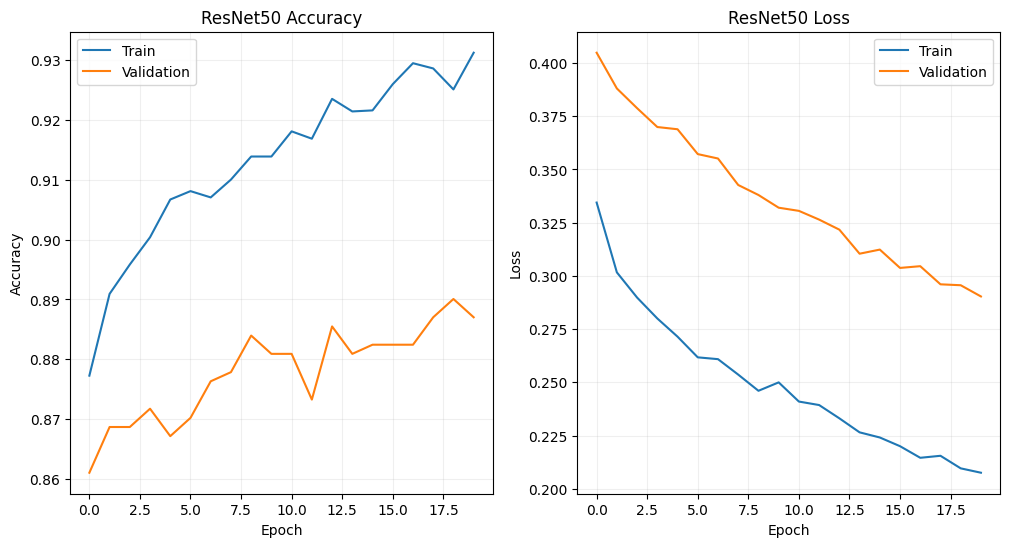

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], )
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('ResNet50 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('ResNet50 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

Analyzing the accuracy and loss graphs, we observe an increasing trend in accuracy and a decreasing trend in loss. The model shows continuous improvement throughout each epoch.

Overall, both the training and validation accuracy display a consistent upward trend, suggesting that the model is learning effectively. The steady decline in loss further reinforces this observation.

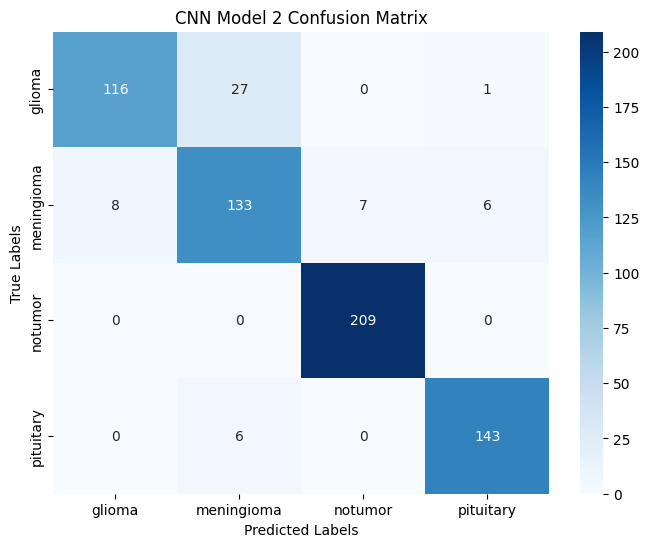

In [ ]:
# Print confusion matrix
con_matrix_ResNet50 = confusion_matrix(y_test_encoded, y_pred_ResNet50)
class_names = label_encoder.classes_

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(con_matrix_ResNet50, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("CNN Model 2 Confusion Matrix")
plt.show()

Looking at the confusion matrix, we observe that our modified ResNet50 model has a few misclassifications, particularly for the 'glioma' and 'meningioma' classes. The model struggles to correctly classify these two groups. Specifically, it misclassified 8 'meningioma' images as 'glioma,' 7 as 'no tumor,' and 6 as 'pituitary.' For the 'glioma' class, 27 images were misclassified as 'meningioma.'

Notably, the 'no tumor' class had zero misclassifications. While the model performs better than our baseline models, it still faces the same challenge in distinguishing between the 'glioma' and 'meningioma' classes.

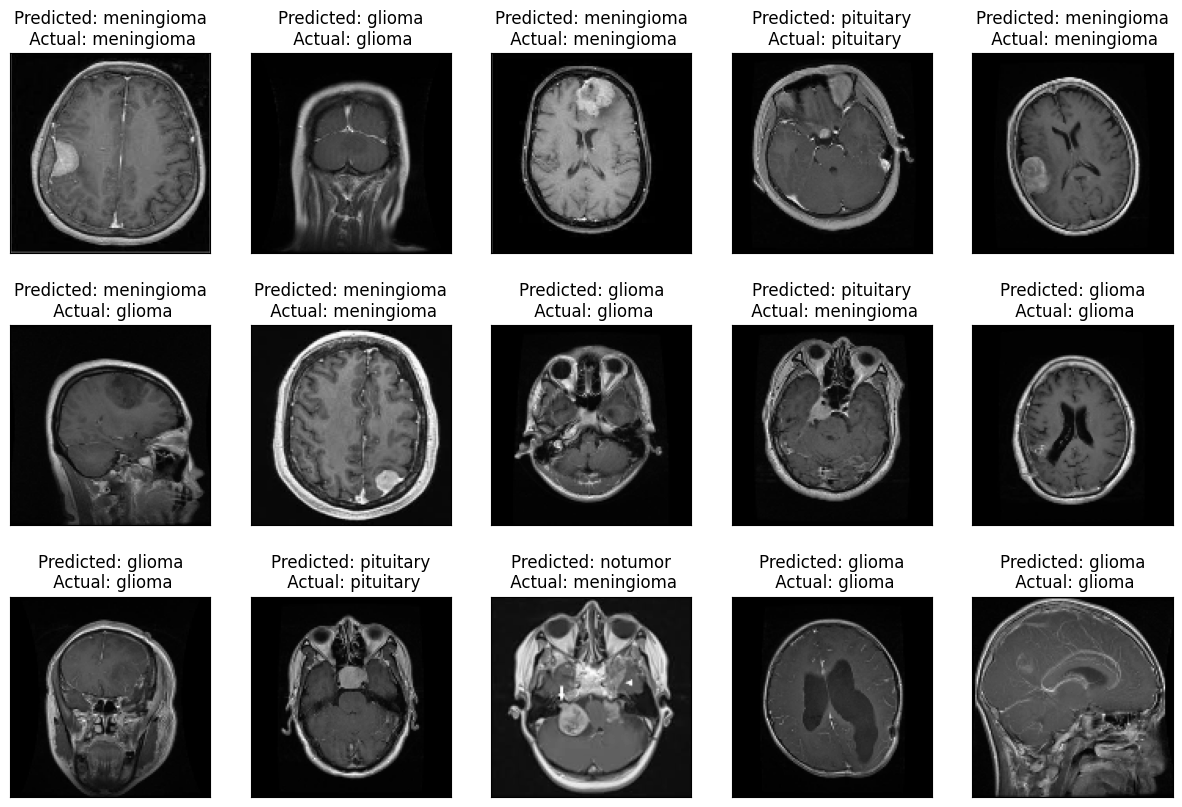

In [ ]:
# Grab the incorrect images
incorrect_photos = y_test_encoded != y_pred_ResNet50

# Set up number of images and the configuration (row x col)
num_images = 15
columns = 5
rows = 3

# Set up subplot
fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 10))

# Flatten axes
ax = ax.flatten()

# Display incorrect images
for i, image in enumerate(X_test[incorrect_photos][:num_images]):
    ax[i].imshow(image, cmap='gray')

    # Get predicted label
    prediction = label_encoder.inverse_transform(y_pred_cnn[incorrect_photos])[i]

    # Get actual label
    actual = label_encoder.inverse_transform(y_test_encoded[incorrect_photos])[i]

    # Set the title of the subplot
    ax[i].set_title(f"Predicted: {prediction}\n Actual: {actual}")

    # Hide the x and y ticks to make
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()
fig.tight_layout()

The same trend persists, 'meningioma' and 'glioma' images are being misclassified. As mentioned previously this is a common pattern among these misclassified images is the presence of a large, visually noticeable tumor, which the model struggles to classify correctly.

In [ ]:
# Save model and weights
ResNet50_model.save("ResNet50_model.h5")
ResNet50_model.save_weights('ResNet50_model.weights.h5')

#### Grad-Cam Visualization

Now that we have created our models, let's evaluate their performance. Grad-CAM is a technique used to understand how convolutional neural networks (CNNs) make classification decisions. The main goal is to visualize whether the model is detecting tumors at the correct locations and assess its overall effectiveness.

**The following VizGradCam code was sourced and adapted from code created by gkeechin. Inspiration was drawn from the original work, and modifications were made to ensure compatibility with our ResNet50 model.**

**Reference: https://github.com/gkeechin/vizgradcam**

In [ ]:
# Get the last convultion layer
last_conv_layer = next(x for x in ResNet50_model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))
last_conv_layer.name

In [ ]:
# Function that creates the GradCAM heatmap overlay.
# All credits goes to gkeechin @ https://github.com/gkeechin/vizgradcam/blob/main/gradcam.py
def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    img = cv2.resize(original_img, (128, 128))
    #expamd dimension and get batch size
    img = np.expand_dims(img, axis=0)
    #predict
    prediction = model.predict(img)
    #prediction index
    prediction_idx = np.argmax(prediction)

    #STEP 2: Create new model
    #specify last convolutional layer
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]

    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))


    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(),
                                (original_img.shape[1],
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)


    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)

    #enlarge plot
    #plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))

In [ ]:
# Load test image
test_img = cv2.imread("/content/data/Testing/pituitary/Te-pi_0016.jpg", cv2.IMREAD_GRAYSCALE)

# Call VizGradCam function and save to heatmap
heatmap = VizGradCAM(ResNet50_model, img_to_array(test_img), plot_results=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


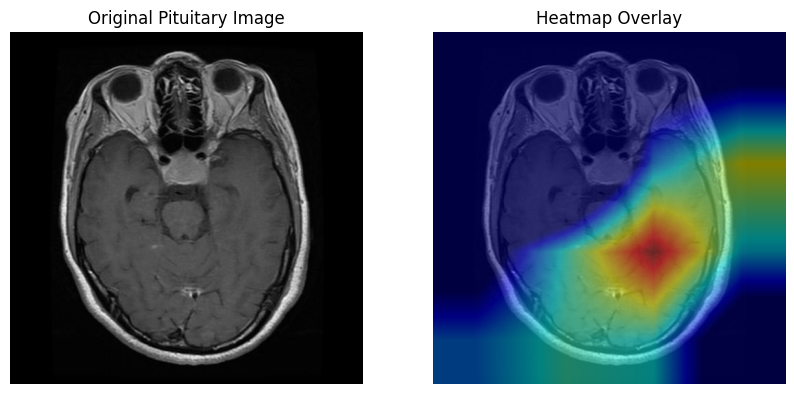

In [ ]:
# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Pituitary Image")
plt.imshow(test_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Heatmap Overlay")
#plt.imshow(image, cmap='gray')
plt.imshow(heatmap)
plt.axis('off')

plt.show()

After applying Grad-CAM to our 'pituitary' image, we can see that the model successfully identified the tumor's location and correctly predicted its type. The dark red region highlights the area where the model detected an anomaly, providing a visual representation of its focus during classification.

## Conclusion

In terms of overall performance, the Advanced CNN model emerged as the best model for image classification. It achieved a test accuracy of approximately 96% and delivered excellent recall scores across all classification groups. Below are the results for all the models:

| Model             | Train Accuracy | Test Accuracy |
|:-------------------:|:----------------:|:---------------:|
| Logistic Regression | 89.74%         | 81.46%        |
| Support Vector Machine (SVM) | 92.49%         | 88.33%        |
| Random Forest      | 83.96%         | 75.97%        |
| Convolutional Baseline Neural Network | 95.95% | 90.69% |
| Convolutional Advanced Neural Network | 98.76% | 96.49% |
| ResNet50 Model | 92.66% | 91.62% |


Now lets compare the recall scores for each classifcation for all the models.

| Model                         | No Tumor Recall | Pituitary Recall | Glioma Recall | Meningioma Recall |
|:-------------------------------:|:-----------------:|:------------------:|:---------------:|:-------------------:|
| Logistic Regression            | 95%             | 95%              | 71%           | 61%               |
| Support Vector Machine (SVM)   | 97%             | 97%              | 82%           | 75%               |
| Random Forest                  | 93%             | 92%              | 63%           | 51%               |
| Convolutional Baseline Neural Network | 99% | 95% | 93% | 68% |
| Convolutional Advanced Neural Network | 100% | 100% | 98% | 87% |
| ResNet50 Model | 100% | 96% | 81% | 86% |

After training and testing multiple models, our Advanced CNN model demonstrated the best overall performance and is ready for production.

In conclusion, we successfully developed a robust model that can assist radiologists and medical professionals in detecting tumors and identifying tumor types at an early stage. This advancement has the potential to increase patient turnover, expedite treatment planning, and significantly accelerate diagnostic times.